# Temporal Convolutional Network
In this notebook, we show an example of how TCNs can be used with darts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models.tcn_model import TCNModel
from darts.preprocessing import ScalerWrapper
from darts.metrics import mape
from darts.utils.missing_values import auto_fillna
from darts.backtesting import backtest_forecasting

Importing plotly failed. Interactive plots will not work.


## Air Passengers Dataset
Since this dataset contains strong yearly seasonality, we will enhance our univariate time series of air passengers to a 13-dimensional multivariate time series containing a one-hot encoded component that for every month.

In [2]:
# Read data:
df = pd.read_csv('examples/AirPassengers.csv', delimiter=",")
ts = TimeSeries.from_dataframe(df, 'Month', ['#Passengers']).add_datetime_attribute('month', True)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp('19580801'))

In [3]:
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(ts)

When instantiating the model, we have to make sure to account for every dimension in the training time series in `input_size`. In this case, since we add a new component for every month, we have a value of 13.
Additionally, since we later want to simulate a historic forecast 6 months into the future, we have to make sure the `output_length` parameter of our `TCNModel` instance has a value of at least 6. 

All the other parameters were chosen by trying out a few different combinations, but they are probably still far from the ideal set.
If we don't specify the `num_layers` parameter, it will be chosen automatically to be the minimum number to ensure full history coverage for every entry in the output, i.e. every output will be dependent on the whole input.

In [4]:
model_air = TCNModel(
    input_size=13,
    n_epochs=1000, 
    input_length=20, 
    output_length=6, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3
)

[2020-07-07 11:42:26,472] INFO | darts.models.tcn_model | Number of layers chosen: 2


In [5]:
model_air.fit(train_transformed, target_indices=[0], val_series=val_transformed, verbose=True)

/Users/guillaume/.pyenv/versions/3.8.3/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


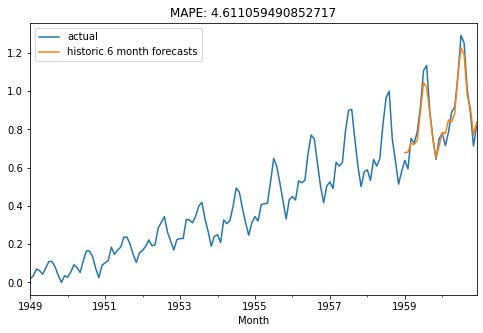

In [6]:
pred_series = backtest_forecasting(
    ts_transformed, 
    model_air,
    pd.Timestamp('19580801'), 
    6,
    target_indices=[0],
    retrain=False
)
plt.figure(figsize=(8,5))
ts_transformed.univariate_component(0).plot(label='actual')
pred_series.plot(label='historic 6 month forecasts')
plt.title('MAPE: {}'.format(mape(pred_series.slice_intersect(ts_transformed.univariate_component(0)), val_transformed.univariate_component(0))))
plt.legend();

## Monthly Sunspots
Let's try using the `TCNModel` on a more complex and much bigger dataset.

In [7]:
df2 = pd.read_csv('examples/monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', ['Sunspots'])
series_sunspot = series_sunspot.add_datetime_attribute('month', True)
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = ScalerWrapper()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer.transform(series_sunspot)

In [8]:
model_sun = TCNModel(
    input_size=13,
    n_epochs=10, 
    input_length=250,
    output_length=36, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1
)

[2020-07-07 11:42:40,406] INFO | darts.models.tcn_model | Number of layers chosen: 6


In [9]:
model_sun.fit(train_sp_transformed, val_sp_transformed, target_indices=[0], verbose=True)

/Users/guillaume/.pyenv/versions/3.8.3/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Training loss: 0.0267, validation loss: 0.0495


In [10]:
pred_series = backtest_forecasting(
    series_sp_transformed, 
    model_sun,
    pd.Timestamp('19401001'), 
    36,
    target_indices=[0],
    stride=6,
    retrain=False,
    verbose=True
)

[2020-07-07 11:42:57,858] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.


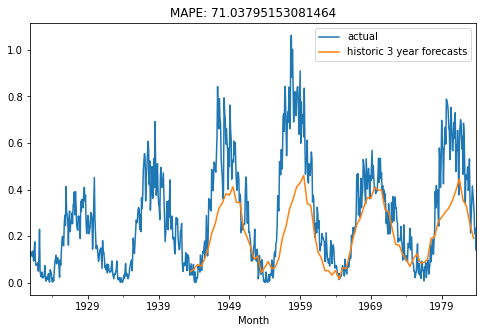

In [11]:
plt.figure(figsize=(8,5))
series_sp_transformed.drop_before(pd.Timestamp('19201001')).univariate_component(0).plot(label='actual')
pred_series.plot(label='historic 3 year forecasts')
plt.title('MAPE: {}'.format(mape(pred_series, val_sp_transformed.univariate_component(0))))
plt.legend()